In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy

from database_credentials import get_database_url
from load_transform import load_transform_combine, pivot

In [2]:
def get_decreasing_trend_ids(data):
    """Return the trend ids of decreasing trends
    
    Args:
        data (dataframe): 
            contains turnip prices with each weekly trend identified
            by trend_id
    
    Returns:
        decreasing_trend_ids (array): 
            contains the trend_id of decreasing trends
    """
    
    pivot_table = pivot(data, is_combined_data=True)
    pivot_table = pivot_table.to_numpy()
    
    # adapted from https://stackoverflow.com/questions/30734258/
    is_decreasing = np.all(pivot_table[:, 1:] < pivot_table[:, :-1], axis=1)
    decreasing_trend_ids = np.where(is_decreasing)[0]
    return decreasing_trend_ids

def get_spike_trend_ids(data):
    """Return the trend ids of trends with spikes
    
    Args:
        data (dataframe): 
            contains turnip prices with each weekly trend identified
            by trend_id
    
    Returns:
        spike_trend_ids (array): 
            contains the trend_id of trends with spikes
    """
    
    pivot_table = pivot(data, is_combined_data=True)
    max_price = pivot_table.max(axis=1)
    
    # prices above percentiles found in data_exploration
    # 177, 252 (95th and 98th percentile)
    is_spike = max_price > 200

    spike_trend_ids = np.where(is_spike)[0]
    return spike_trend_ids

def get_unknown_trend_ids(data, decreasing_trend_ids, spike_trend_ids):
    """Return the trend ids of unknown trends
    
    Args:
        data (dataframe): 
            contains turnip prices with each weekly trend identified
            by trend_id
    
    Returns:
        unknown_trend_ids (array): 
            contains the trend_id of unknown trends
    """
    
    all_trend_ids = data['trend_id'].unique()
    known_trend_ids = np.concatenate([decreasing_trend_ids, spike_trend_ids])
    known_trend_mask = ~np.isin(all_trend_ids, known_trend_ids)
    unknown_trend_ids = all_trend_ids[known_trend_mask]
    return unknown_trend_ids

def get_sample_trends(data, trend_ids, n_samples):
    """Return the a sample of trends from the given trend_ids
    
    Args:
        data (dataframe): 
            contains turnip prices with each weekly trend identified
            by trend_id
            
        trend_ids (array): 
            contains the trend_ids from which random samples are
            selected
    
    Returns:
        sample_trends (dataframe): 
            contains the sample of trends
    """
    
    num_trend_ids = trend_ids.shape[0]
    n_samples = min(num_trend_ids, n_samples)
    
    sample_trend_ids = np.random.choice(
        trend_ids, 
        replace=False, 
        size=(n_samples)
    )
    sample_trend_indices = data['trend_id'].isin(sample_trend_ids)
    sample_trends = data.loc[sample_trend_indices, :]
    
    return sample_trends

In [3]:
plt.style.use('ggplot')
sns.set_style('white')

In [4]:
database_url = get_database_url()
engine = sqlalchemy.create_engine(database_url)
connection = engine.connect()

In [5]:
# load data week by week, format and combine weekly turnip price data
num_weeks = 4
complete_sell_data = load_transform_combine(num_weeks, connection)
xticks = complete_sell_data['weekday_observed'].unique()

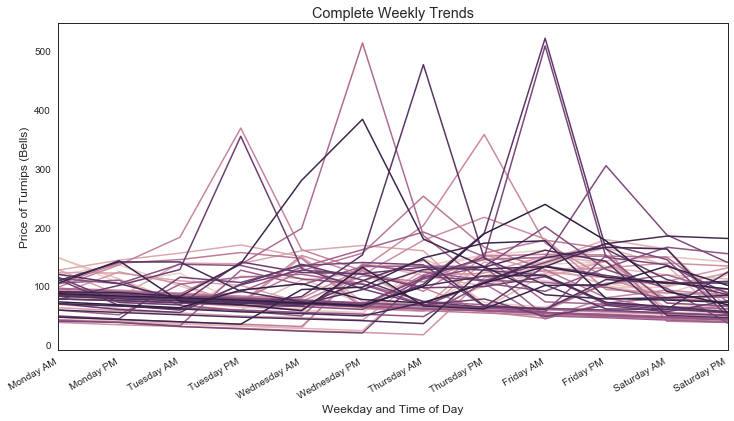

In [6]:
plt.figure(figsize=(12, 6))
complete_sell_data_plot = sns.lineplot(
    x='weekday_observed', 
    y='price', 
    hue='trend_id',
    data=complete_sell_data, 
    sort=False,
    legend=False
)
complete_sell_data_plot.set(
    title='Complete Weekly Trends',
    xlabel='Weekday and Time of Day',
    ylabel='Price of Turnips (Bells)'
)
complete_sell_data_plot.set_xticklabels(xticks, rotation=30, ha='right')
plt.xlim(0, 11)
plt.show()

After loading in, transforming and combining the weekly turnip prices, trends can be viewed together within the span of 6 days as opposed to multiple weeks and I can now attempt to classify the trends.

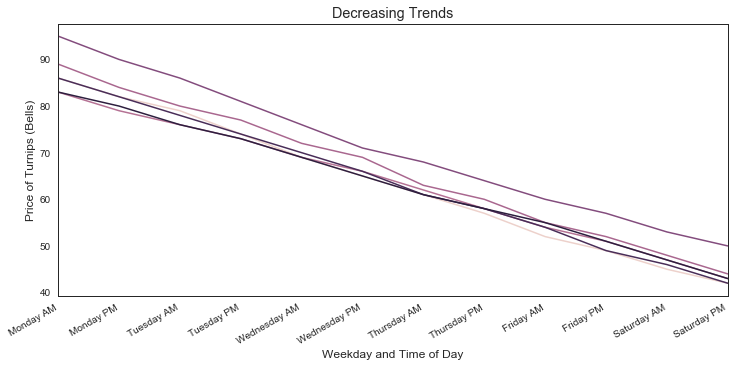

In [7]:
decreasing_trend_ids = get_decreasing_trend_ids(complete_sell_data)
decreasing_trend_samples = get_sample_trends(
    data=complete_sell_data,
    trend_ids=decreasing_trend_ids,
    n_samples=10
)

plt.figure(figsize=(12, 5))
decreasing_trend_plot = sns.lineplot(
    x='weekday_observed', 
    y='price', 
    hue='trend_id', 
    data=decreasing_trend_samples, 
    sort=False,
    legend=False
)
decreasing_trend_plot.set(
    title='Decreasing Trends',
    xlabel='Weekday and Time of Day',
    ylabel='Price of Turnips (Bells)'
)
decreasing_trend_plot.set_xticklabels(xticks, rotation=30, ha='right')
plt.xlim(0, 11)
plt.show()

Decreasing were identified based on how turnip prices strictly decreased throughout the week. 

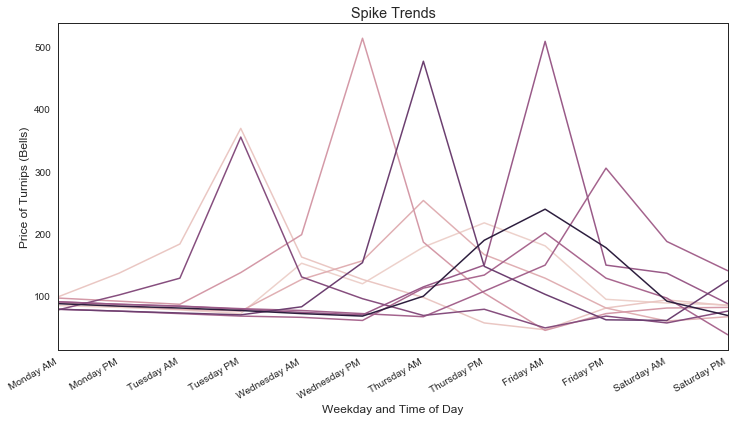

In [25]:
spike_trend_ids = get_spike_trend_ids(complete_sell_data)
spike_trend_samples = get_sample_trends(
    data=complete_sell_data,
    trend_ids=spike_trend_ids,
    n_samples=10
)

plt.figure(figsize=(12, 6))
spike_trend_plot = sns.lineplot(
    x='weekday_observed', 
    y='price', 
    hue='trend_id', 
    data=spike_trend_samples, 
    sort=False,
    legend=False
)
spike_trend_plot.set(
    title='Spike Trends',
    xlabel='Weekday and Time of Day',
    ylabel='Price of Turnips (Bells)'
)
spike_trend_plot.set_xticklabels(xticks, rotation=30, ha='right')
plt.xlim(0, 11)
plt.show()

Spike trends on the other hand, were identified based on whether or not the maximum turnip price was above 200 bells (an arbitrary number of bells between the 95th and 98th percentile. Disadvantages of this include false negatives if the number of bells is too high, false positives if the number of bells is too low along with the possibility of the percentiles changing as more data is added.

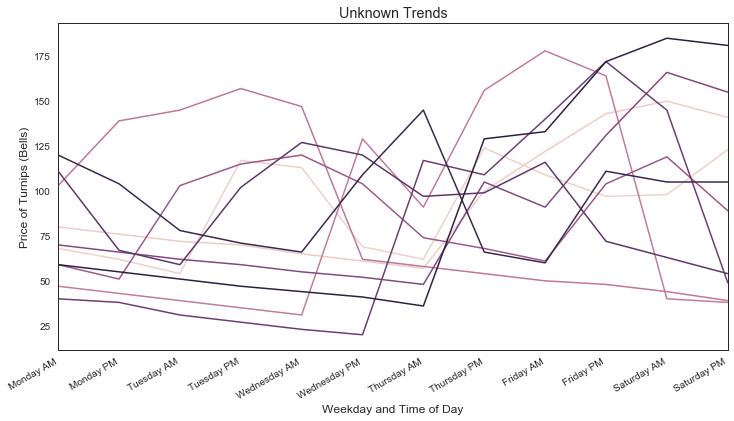

In [10]:
unknown_trend_ids = get_unknown_trend_ids(
    complete_sell_data, 
    decreasing_trend_ids, 
    spike_trend_ids
)

unknown_trend_samples = get_sample_trends(
    data=complete_sell_data,
    trend_ids=unknown_trend_ids,
    n_samples=10
)

plt.figure(figsize=(12, 6))
unknown_trend_plot = sns.lineplot(
    x='weekday_observed', 
    y='price', 
    hue='trend_id', 
    data=unknown_trend_samples, 
    sort=False,
    legend=False
)
unknown_trend_plot.set(
    title='Unknown Trends',
    xlabel='Weekday and Time of Day',
    ylabel='Price of Turnips (Bells)'
)
unknown_trend_plot.set_xticklabels(xticks, rotation=30, ha='right')
plt.xlim(0, 11)
plt.show()

Finally, the rest are unknown trends that I could not classify.

In [11]:
connection.close()
engine.dispose()